# FAQs

## I'm confused about how to specify random-effects in LMMs/GLMMs

```python
# Random intercepts only
(1 | Group)

# Random slopes only
(0 + Variable | Group)

# Random intercepts and slopes (and their correlation)
(Variable | Group)

# Random intercepts and slopes (without their correlation)
(1 | Group) + (0 + Variable | Group)

# Same as above but will not separate factors (see: https://rdrr.io/cran/lme4/man/expandDoubleVerts.html)
(Variable || Group)

# Random intercept and slope for more than one variable (and their correlations)
(Variable_1 + Variable_2 | Group)

# Random intercepts, slopes, correlations for multiple random-effects
(Variable | Subject) + (Variable | Item)
```

## I want traditional ANOVA main-effects and interactions

- Before using `.fit()` use `.set_factors('categorical_var')` to tell the model what your categorical predictors are
- Call `.anova()` which will automatically return correctly coded Type-III Sum-of-Squares omninbus $F$ tests

## I want my model parameters to reflect specific factor-level contrasts

- Before using `.fit()` use `.set_factors({'condition': ['a', 'b', 'c'})` to set your categorical predictors and their level order
- Either use `.set_contrasts` to use one of the default contrasts, e.g. `.set_contrasts({'condition': 'contr.poly'})`
- Or set a custom contrast in *human-readable-format*, e.g. level `'c'` minus the mean of levels `'a'` and `'b'`: `.set_contrasts({'condition': [-.5, -.5, 1]})`
    - You don't need to specify all $k-1$ contrasts for a $k$ level factor; `pymer4` will auto-populate the remaining orthogonal contrasts
- Use `.fit()` to get parameter estimates reflecting your desired comparison(s)

## I want explore additional custom comparison between factors levels (e.g. post-hoc tests)

- After using `.fit()` use `.emmeans()` or `.empredict()` to generate specific marginal estimates
- Use the `contrasts`, `by`, or `at` arguments to perform specific comparisons
- Use `contrasts='pairwise'` to calculate all pairwise comparison between factor levels

## I want to perform an unequal-variances t-test

In situations when group sizes are different you may want to account for unequal variances.  

In [1]:
from pymer4.models import lm
from pymer4 import load_dataset
import seaborn as sns
import numpy as np
import polars as pl
from polars import col

df = load_dataset("credit")

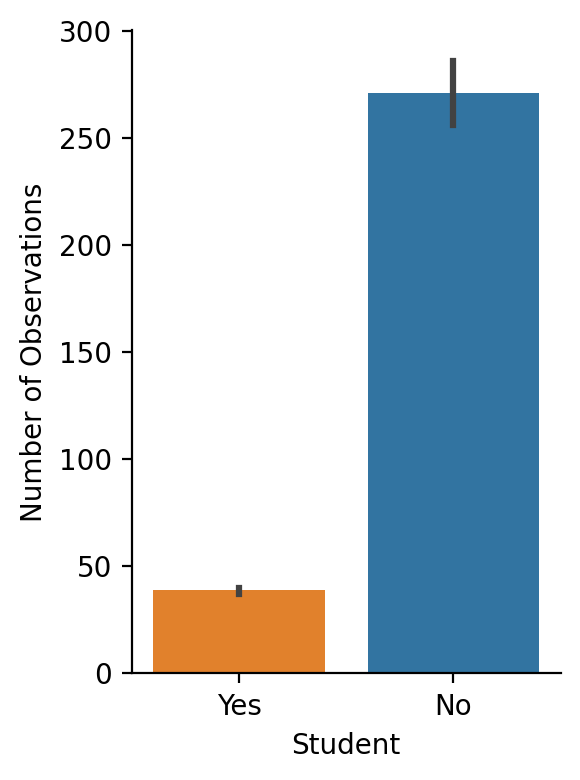

In [10]:
grid = sns.catplot(
    x="Student",
    y="Balance",
    kind="bar",
    hue="Student",
    order=["Yes", "No"],
    aspect=0.75,
    height=4,
    estimator=np.count_nonzero,
    data=df.to_pandas(),
)
grid.set_ylabels('Number of Observations');

In regression terms this is a *weighted-least-squares* (WLS) model, where the weights are the inverse of each group's variance

In [14]:
model = lm('Balance ~ Student', data=df)
model.set_factors('Student')

# Create column called weights which is equal to 1 / var for each group
student = df.filter(col('Student') == 'Yes').select('Balance')
non_student = df.filter(col('Student') == 'No').select('Balance')

model.data = model.data.with_columns(

    weights=pl.when(col("Student") == "No")

    .then(1 / non_student.var(ddof=1).item())

    .otherwise(1 / student.var(ddof=1).item())
)

# Use new column as weights
model.fit(weights=model.data["weights"].to_numpy())

# Check out t-statistic
model.result_fit[-1, 't_stat']

4.902778661363219

Which is equivalent to welch's t-test calculated in `scipy`

In [11]:
from scipy.stats import ttest_ind


# equal_var = False uses satterthwaite approximation
results = ttest_ind(student, non_student, equal_var=False)
print(f"t= {results.statistic[0]:.3f} p = {results.pvalue[0]:.2f}")

t= 4.903 p = 0.00
